Промежуточная аттестация 3

Классификация

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,  # Метрика точности для классификации
    mean_squared_error,  # Средняя квадратичная ошибка для регрессии
    r2_score,  # Коэффициент детерминации для регрессии
    classification_report  # Отчет о классификации
)
from joblib import dump
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

In [2]:
train_df=pd.read_csv('loan_data.csv')

In [3]:
pd.options.display.float_format = '{:,.2f}'.format
train_df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.00,female,Master,"71,948.00",0,RENT,"35,000.00",PERSONAL,16.02,0.49,3.00,561,No,1
1,21.00,female,High School,"12,282.00",0,OWN,"1,000.00",EDUCATION,11.14,0.08,2.00,504,Yes,0
2,25.00,female,High School,"12,438.00",3,MORTGAGE,"5,500.00",MEDICAL,12.87,0.44,3.00,635,No,1
3,23.00,female,Bachelor,"79,753.00",0,RENT,"35,000.00",MEDICAL,15.23,0.44,2.00,675,No,1
4,24.00,male,Master,"66,135.00",1,RENT,"35,000.00",MEDICAL,14.27,0.53,4.00,586,No,1


In [4]:
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
person_age,0.00
person_gender,0.00
person_education,0.00
person_income,0.00
person_emp_exp,0.00
person_home_ownership,0.00
loan_amnt,0.00
loan_intent,0.00
loan_int_rate,0.00
loan_percent_income,0.00


Нет пропушенных данных.

Разделяем датасет на категориальные и числовые переменные для EDA.

In [4]:
category_col = train_df.select_dtypes(include=['object']).columns.tolist()
category_col

['person_gender',
 'person_education',
 'person_home_ownership',
 'loan_intent',
 'previous_loan_defaults_on_file']

In [5]:
train_df_cat = train_df[category_col]
number_col = train_df.select_dtypes(include=['number']).columns.tolist()
train_df_num = train_df[number_col]

# EDA

Для числовых переменных

In [56]:
train_df_num.describe(include='all')

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,"45,000.00","45,000.00","45,000.00","45,000.00","45,000.00","45,000.00","45,000.00","45,000.00","45,000.00"
mean,27.76,"80,319.05",5.41,"9,583.16",11.01,0.14,5.87,632.61,0.22
std,6.05,"80,422.50",6.06,"6,314.89",2.98,0.09,3.88,50.44,0.42
min,20.00,"8,000.00",0.00,500.00,5.42,0.00,2.00,390.00,0.00
25%,24.00,"47,204.00",1.00,"5,000.00",8.59,0.07,3.00,601.00,0.00
50%,26.00,"67,048.00",4.00,"8,000.00",11.01,0.12,4.00,640.00,0.00
75%,30.00,"95,789.25",8.00,"12,237.25",12.99,0.19,8.00,670.00,0.00
max,144.00,"7,200,766.00",125.00,"35,000.00",20.00,0.66,30.00,850.00,1.00


In [10]:
#Находим медиану
median_df = pd.DataFrame({'Медиана': train_df_num.median()})

median_df

,Медиана
person_age,26.00
person_income,"67,048.00"
person_emp_exp,4.00
loan_amnt,"8,000.00"
loan_int_rate,11.01
loan_percent_income,0.12
cb_person_cred_hist_length,4.00
credit_score,640.00
loan_status,0.00


In [11]:
#Находим дисперсию
var_df = pd.DataFrame({'Диспрерсия': train_df_num.var()})

var_df

,Диспрерсия
person_age,36.54
person_income,"6,467,778,286.20"
person_emp_exp,36.77
loan_amnt,"39,877,793.91"
loan_int_rate,8.87
loan_percent_income,0.01
cb_person_cred_hist_length,15.05
credit_score,"2,543.78"
loan_status,0.17


Для категориальных

In [12]:
#Находим кол-во уникальных значений
unique_df = pd.DataFrame({'Уникальных значений в столбце': train_df_cat.nunique()})
unique_df

,Уникальных значений в столбце
person_gender,2
person_education,5
person_home_ownership,4
loan_intent,6
previous_loan_defaults_on_file,2


In [13]:
#Находим моду столбцов
mode_df =  pd.DataFrame({'Мода в столбце':train_df_cat.mode().loc[0]})
mode_df

,Мода в столбце
person_gender,male
person_education,Bachelor
person_home_ownership,RENT
loan_intent,EDUCATION
previous_loan_defaults_on_file,Yes


In [14]:
for col in category_col:
    print(f"Unique values in {col}: {train_df[col].unique()}")

Unique values in person_gender: ['female' 'male']
Unique values in person_education: ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
Unique values in person_home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Unique values in loan_intent: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
Unique values in previous_loan_defaults_on_file: ['No' 'Yes']


Проверим есть ли дубликаты

In [15]:
duplicates = train_df[train_df.duplicated()]
duplicates

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status


Проверим есть ли выбросы

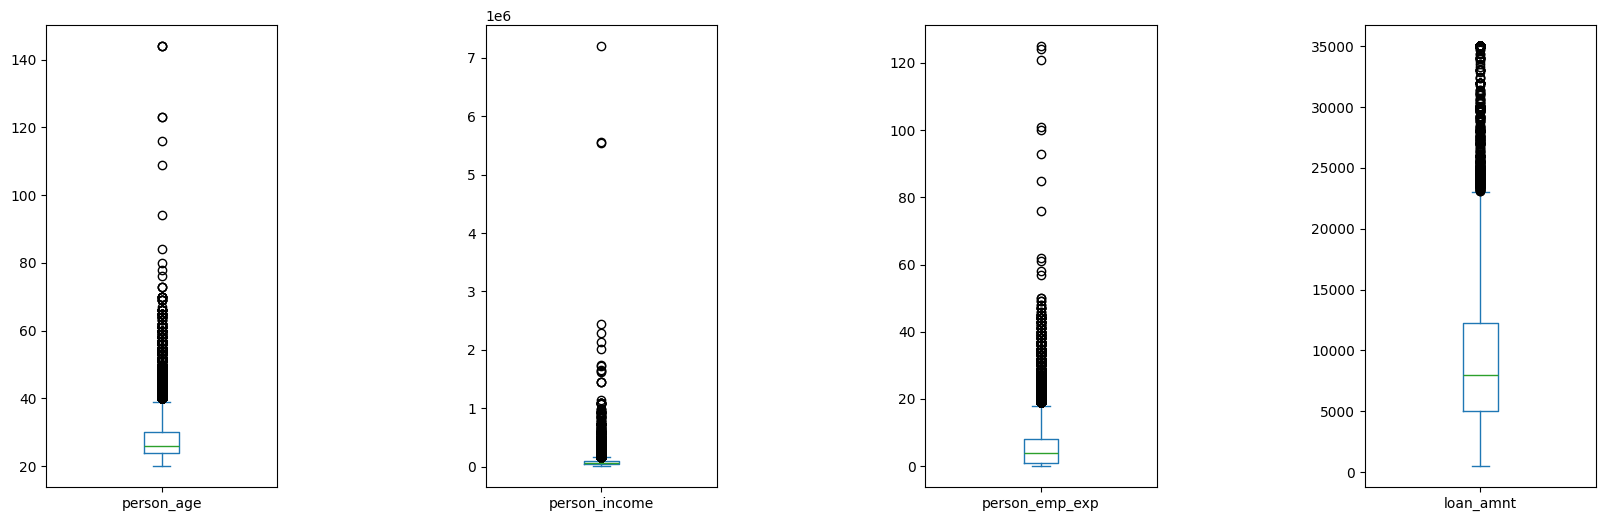

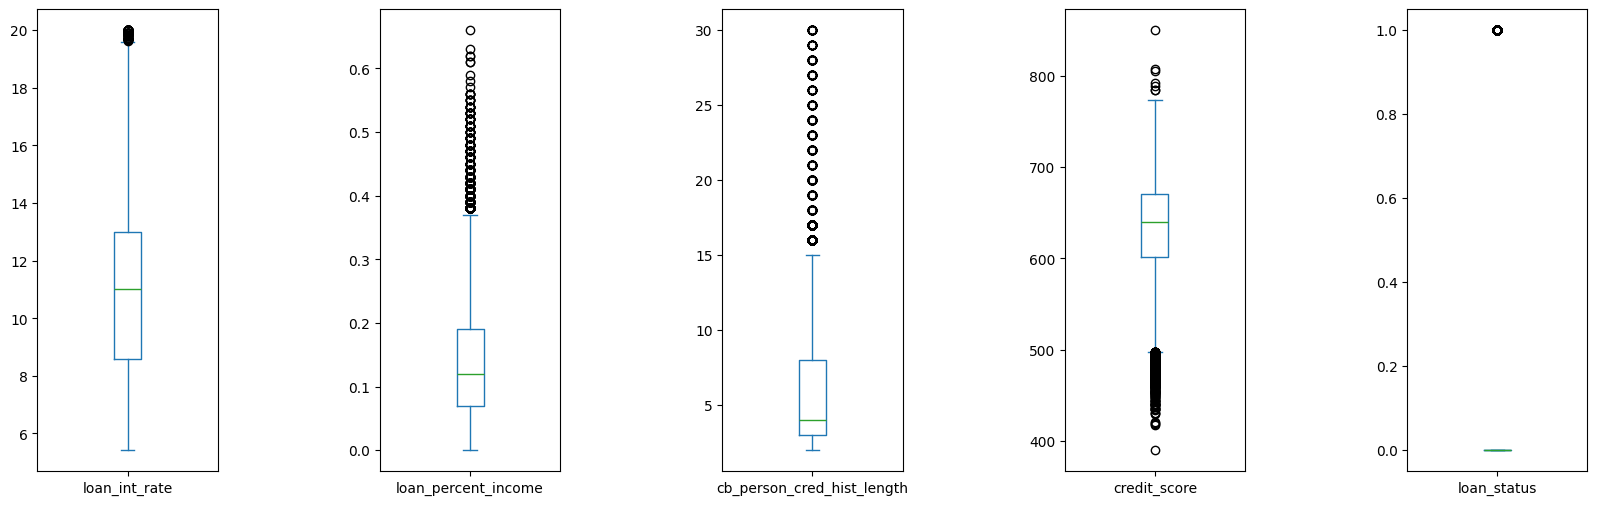

In [64]:
train_df.iloc[:,:7].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
train_df.iloc[:,7:].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

Выбросы есть у всех числовых колонок в датасете.

Если убрать выбросы из всех колонок, кроме целевой переменной(loan_status) качество моделей снижается, поэтому в этом задании не будут убираться выбросы.

Посмотрим распределение в категориальных колонках

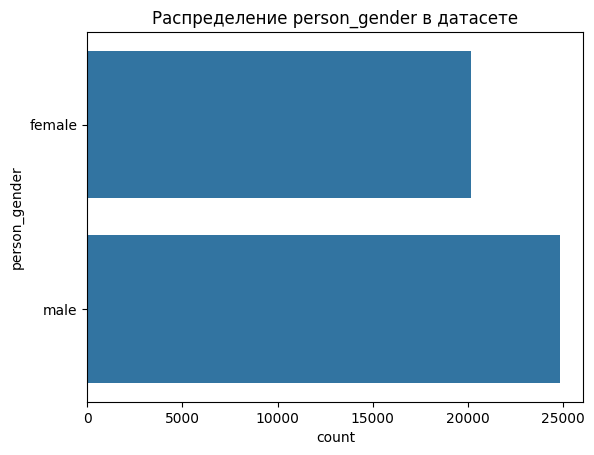

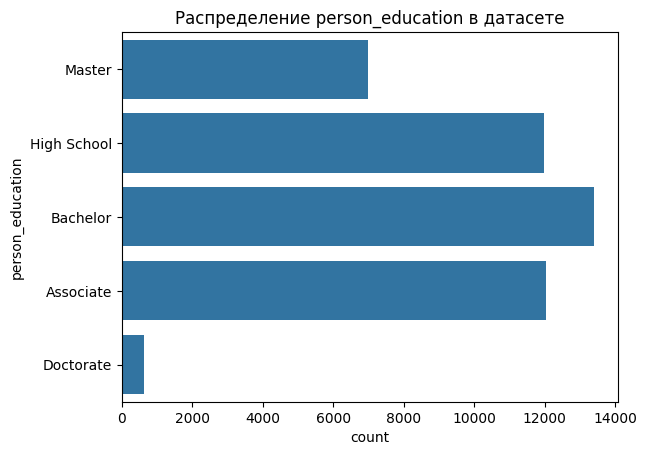

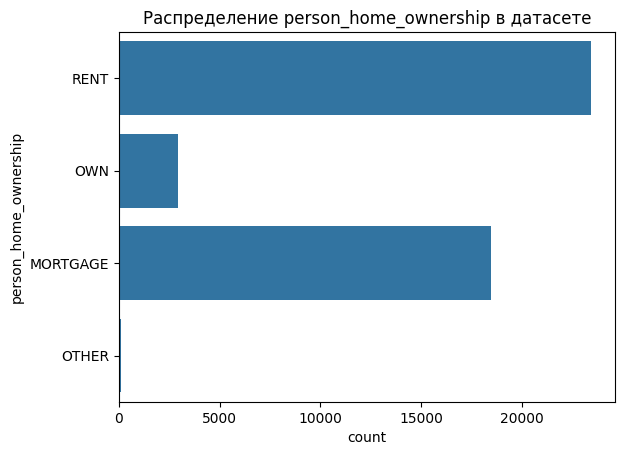

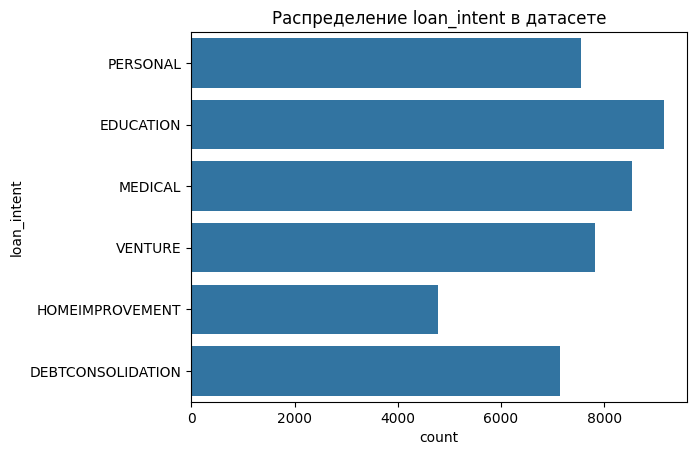

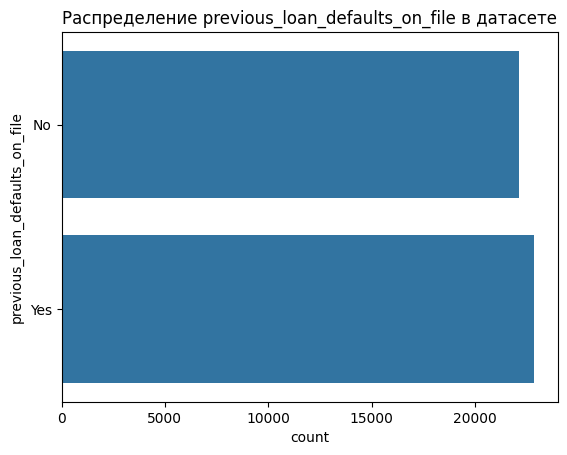

In [176]:
for column in train_df_cat.columns:
    sns.countplot(train_df_cat[column])
    plt.title(f"Распределение {column} в датасете")
    plt.show()

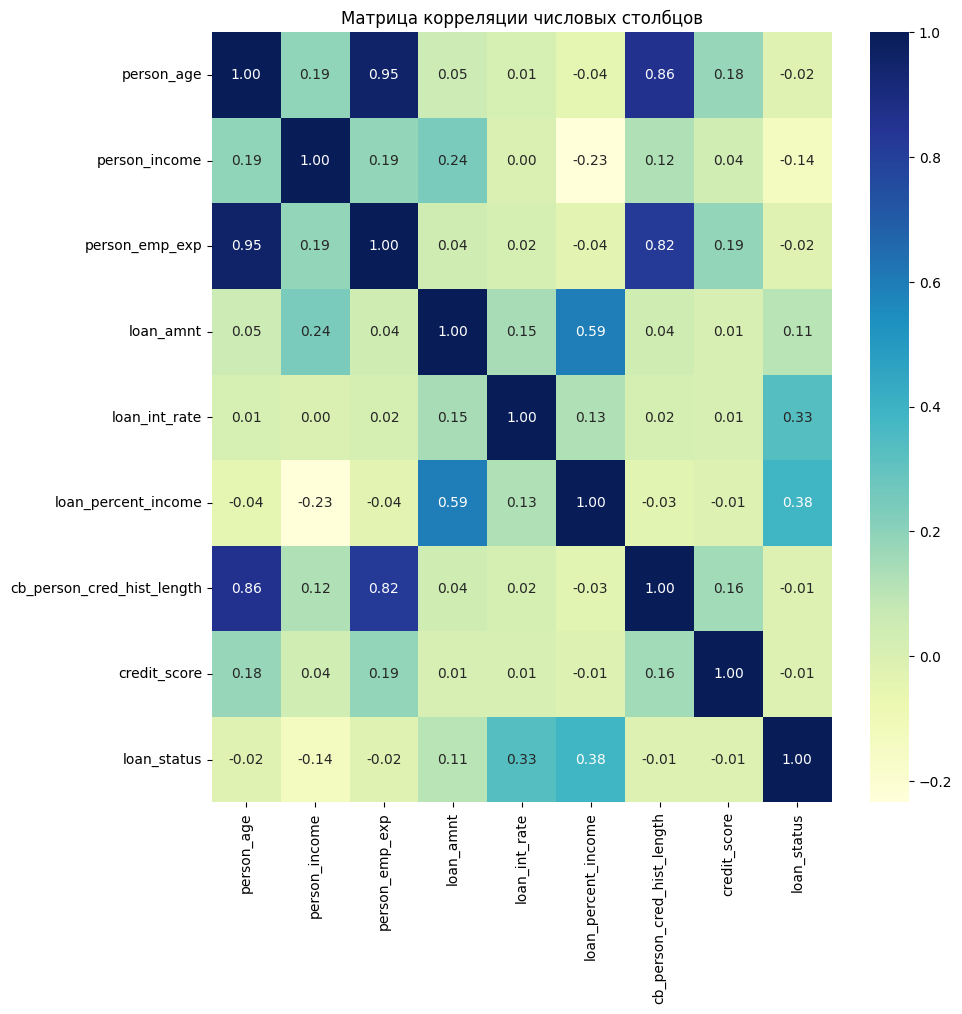

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(train_df_num.corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Матрица корреляции числовых столбцов")
plt.show()

У cb_person_cred_hist_length есть высокая корреляция с двумя другими переменными. Корреляция не слишком критичная, поэтому мы оставляем все столбцы

# Подготовка датасета

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
sex = encoder.fit_transform(train_df['person_gender'])
encoded_df = train_df.drop("person_gender", axis=1)
encoded_df['person_gender'] = sex
encoded_df

,person_age,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,person_gender
0,22.00,Master,"71,948.00",0,RENT,"35,000.00",PERSONAL,16.02,0.49,3.00,561,No,1,0
1,21.00,High School,"12,282.00",0,OWN,"1,000.00",EDUCATION,11.14,0.08,2.00,504,Yes,0,0
2,25.00,High School,"12,438.00",3,MORTGAGE,"5,500.00",MEDICAL,12.87,0.44,3.00,635,No,1,0
3,23.00,Bachelor,"79,753.00",0,RENT,"35,000.00",MEDICAL,15.23,0.44,2.00,675,No,1,0
4,24.00,Master,"66,135.00",1,RENT,"35,000.00",MEDICAL,14.27,0.53,4.00,586,No,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.00,Associate,"47,971.00",6,RENT,"15,000.00",MEDICAL,15.66,0.31,3.00,645,No,1,1
44996,37.00,Associate,"65,800.00",17,RENT,"9,000.00",HOMEIMPROVEMENT,14.07,0.14,11.00,621,No,1,0
44997,33.00,Associate,"56,942.00",7,RENT,"2,771.00",DEBTCONSOLIDATION,10.02,0.05,10.00,668,No,1,1
44998,29.00,Bachelor,"33,164.00",4,RENT,"12,000.00",EDUCATION,13.23,0.36,6.00,604,No,1,1


In [7]:
previous_loan_defaults_on_file = encoder.fit_transform(encoded_df['previous_loan_defaults_on_file'])
encoded_df = encoded_df.drop("previous_loan_defaults_on_file", axis=1)
encoded_df['previous_loan_defaults_on_file'] = previous_loan_defaults_on_file
encoded_df

,person_age,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender,previous_loan_defaults_on_file
0,22.00,Master,"71,948.00",0,RENT,"35,000.00",PERSONAL,16.02,0.49,3.00,561,1,0,0
1,21.00,High School,"12,282.00",0,OWN,"1,000.00",EDUCATION,11.14,0.08,2.00,504,0,0,1
2,25.00,High School,"12,438.00",3,MORTGAGE,"5,500.00",MEDICAL,12.87,0.44,3.00,635,1,0,0
3,23.00,Bachelor,"79,753.00",0,RENT,"35,000.00",MEDICAL,15.23,0.44,2.00,675,1,0,0
4,24.00,Master,"66,135.00",1,RENT,"35,000.00",MEDICAL,14.27,0.53,4.00,586,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.00,Associate,"47,971.00",6,RENT,"15,000.00",MEDICAL,15.66,0.31,3.00,645,1,1,0
44996,37.00,Associate,"65,800.00",17,RENT,"9,000.00",HOMEIMPROVEMENT,14.07,0.14,11.00,621,1,0,0
44997,33.00,Associate,"56,942.00",7,RENT,"2,771.00",DEBTCONSOLIDATION,10.02,0.05,10.00,668,1,1,0
44998,29.00,Bachelor,"33,164.00",4,RENT,"12,000.00",EDUCATION,13.23,0.36,6.00,604,1,1,0


In [8]:
person_education_map = {'High School' : 0, 'Associate' : 1, 'Bachelor' : 2, 'Master' : 3,'Doctorate' : 4}
encoded_df['person_education'] = encoded_df['person_education'].map(person_education_map)
encoded_df

,person_age,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender,previous_loan_defaults_on_file
0,22.00,3,"71,948.00",0,RENT,"35,000.00",PERSONAL,16.02,0.49,3.00,561,1,0,0
1,21.00,0,"12,282.00",0,OWN,"1,000.00",EDUCATION,11.14,0.08,2.00,504,0,0,1
2,25.00,0,"12,438.00",3,MORTGAGE,"5,500.00",MEDICAL,12.87,0.44,3.00,635,1,0,0
3,23.00,2,"79,753.00",0,RENT,"35,000.00",MEDICAL,15.23,0.44,2.00,675,1,0,0
4,24.00,3,"66,135.00",1,RENT,"35,000.00",MEDICAL,14.27,0.53,4.00,586,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.00,1,"47,971.00",6,RENT,"15,000.00",MEDICAL,15.66,0.31,3.00,645,1,1,0
44996,37.00,1,"65,800.00",17,RENT,"9,000.00",HOMEIMPROVEMENT,14.07,0.14,11.00,621,1,0,0
44997,33.00,1,"56,942.00",7,RENT,"2,771.00",DEBTCONSOLIDATION,10.02,0.05,10.00,668,1,1,0
44998,29.00,2,"33,164.00",4,RENT,"12,000.00",EDUCATION,13.23,0.36,6.00,604,1,1,0


In [9]:
category_col_enc = encoded_df.select_dtypes(include=['object']).columns.tolist()
category_col_enc

['person_home_ownership', 'loan_intent']

In [10]:
from sklearn.preprocessing import OneHotEncoder

category_col_enc = encoded_df.select_dtypes(include=['object']).columns.tolist()
for col in category_col_enc:
    onehotencoder = OneHotEncoder()
    oe_results = onehotencoder.fit_transform(encoded_df[[col]])
    encoded_df = encoded_df.join(pd.DataFrame(oe_results.toarray(), columns=onehotencoder.get_feature_names_out()))
encoded_df = encoded_df.drop(category_col_enc, axis=1)
encoded_df.head()

,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,...,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22.00,3,"71,948.00",0,"35,000.00",16.02,0.49,3.00,561,1,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
1,21.00,0,"12,282.00",0,"1,000.00",11.14,0.08,2.00,504,0,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,25.00,0,"12,438.00",3,"5,500.00",12.87,0.44,3.00,635,1,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,23.00,2,"79,753.00",0,"35,000.00",15.23,0.44,2.00,675,1,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
4,24.00,3,"66,135.00",1,"35,000.00",14.27,0.53,4.00,586,1,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [11]:
encoded_df

,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,...,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22.00,3,"71,948.00",0,"35,000.00",16.02,0.49,3.00,561,1,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
1,21.00,0,"12,282.00",0,"1,000.00",11.14,0.08,2.00,504,0,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,25.00,0,"12,438.00",3,"5,500.00",12.87,0.44,3.00,635,1,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,23.00,2,"79,753.00",0,"35,000.00",15.23,0.44,2.00,675,1,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
4,24.00,3,"66,135.00",1,"35,000.00",14.27,0.53,4.00,586,1,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.00,1,"47,971.00",6,"15,000.00",15.66,0.31,3.00,645,1,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
44996,37.00,1,"65,800.00",17,"9,000.00",14.07,0.14,11.00,621,1,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
44997,33.00,1,"56,942.00",7,"2,771.00",10.02,0.05,10.00,668,1,...,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
44998,29.00,2,"33,164.00",4,"12,000.00",13.23,0.36,6.00,604,1,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00


In [12]:
encoded_df.info(memory_usage=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_education                45000 non-null  int64  
 2   person_income                   45000 non-null  float64
 3   person_emp_exp                  45000 non-null  int64  
 4   loan_amnt                       45000 non-null  float64
 5   loan_int_rate                   45000 non-null  float64
 6   loan_percent_income             45000 non-null  float64
 7   cb_person_cred_hist_length      45000 non-null  float64
 8   credit_score                    45000 non-null  int64  
 9   loan_status                     45000 non-null  int64  
 10  person_gender                   45000 non-null  int64  
 11  previous_loan_defaults_on_file  45000 non-null  int64  
 12  person_home_ownership_MORTGAGE  

Уменьшим размер датасета.

In [13]:
int_cols = encoded_df.select_dtypes('int').columns

float_cols = encoded_df.select_dtypes('float').columns
for col in int_cols:
    encoded_df[col] = pd.to_numeric(encoded_df[col], downcast='integer')
for col in float_cols:
    encoded_df[col] = pd.to_numeric(encoded_df[col], downcast='float')

In [14]:
encoded_df.info(memory_usage=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float32
 1   person_education                45000 non-null  int8   
 2   person_income                   45000 non-null  float32
 3   person_emp_exp                  45000 non-null  int8   
 4   loan_amnt                       45000 non-null  float32
 5   loan_int_rate                   45000 non-null  float32
 6   loan_percent_income             45000 non-null  float32
 7   cb_person_cred_hist_length      45000 non-null  float32
 8   credit_score                    45000 non-null  int16  
 9   loan_status                     45000 non-null  int8   
 10  person_gender                   45000 non-null  int8   
 11  previous_loan_defaults_on_file  45000 non-null  int8   
 12  person_home_ownership_MORTGAGE  

In [15]:
encoded_df.to_csv('encoded_df.csv', sep=',', index=False, encoding='utf-8')

# Обучение моделей

In [30]:
my_random_state = 42

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(encoded_df.drop('loan_status', axis=1))
scaled_features = scaler.transform(encoded_df.drop('loan_status', axis=1))
scaled_data = pd.DataFrame(scaled_features, columns = encoded_df.drop('loan_status', axis=1).columns)

In [36]:
X = encoded_df.drop('loan_status', axis=1)
X_scaled = scaled_data
y = encoded_df['loan_status']

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(X)
reduced_data_pca_scaled = pca.fit_transform(X_scaled)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(reduced_data_pca, y, train_size=0.3, random_state = my_random_state)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(reduced_data_pca_scaled, y, train_size=0.3, random_state = my_random_state)

Функция для оценки моделей

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

def calculate_metrics_and_plot_roc(model, X_train, y_train, X_test, y_test):
    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание вероятностей на обучающей и тестовой выборке
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Расчет AUC-ROC
    roc_auc_train = roc_auc_score(y_train, y_train_proba)
    roc_auc_test = roc_auc_score(y_test, y_test_proba)
    print(f"ROC-AUC Train: {roc_auc_train:.2f}")
    print(f"ROC-AUC Test: {roc_auc_test:.2f}")

    # Построение ROC-кривой
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC Curve Train')
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC Curve Test')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({type(model).__name__})')
    plt.legend()
    plt.show()

    # Поиск порога, максимизирующего F1-score
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = [f1_score(y_test, y_test_proba >= t) for t in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal Threshold: {optimal_threshold:.2f}")

    # Пересчет метрик с учетом оптимального порога
    y_train_pred_optimal = (y_train_proba >= optimal_threshold).astype(int)
    y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

    train_precision = precision_score(y_train, y_train_pred_optimal)
    train_accuracy = accuracy_score(y_train, y_train_pred_optimal)
    train_recall = recall_score(y_train, y_train_pred_optimal)
    test_precision = precision_score(y_test, y_test_pred_optimal)
    test_accuracy = accuracy_score(y_test, y_test_pred_optimal)
    test_recall = recall_score(y_test, y_test_pred_optimal)
    test_f1 = f1_score(y_test, y_test_pred_optimal)

    print(f"Optimal Training Precision: {train_precision:.2f}")
    print(f"Optimal Training Аccuracy: {train_accuracy:.2f}")
    print(f"Optimal Training Recall: {train_recall:.2f}")
    print(f"Optimal Test Precision: {test_precision:.2f}")
    print(f"Optimal Test Аccuracy: {test_accuracy:.2f}")
    print(f"Optimal Test Recall: {test_recall:.2f}")
    print(f"Optimal Test f1_score: {test_f1:.2f}")

    metrics = {
        'params': [
            'Training_Precision', 'Test_Precision',
            'Training_Аccuracy','Test_Аccuracy',
            'Training_Recall', 'Test_Recall',
            'ROC_AUC_Train', 'ROC_AUC_Test',
            'f1_score_Test'
        ],
        'values': [
            train_precision, test_precision,
            train_accuracy, test_accuracy,
            train_recall, test_recall,
            roc_auc_train, roc_auc_test,
            test_f1
        ]
    }

    return metrics

## DecisionTreeClassifier

In [41]:
from sklearn.model_selection import GridSearchCV

def findDecisionTreeClassifier(X_train, y_train):

    param_grid = {
        'max_depth': range(1, 10, 1),
        'min_samples_leaf': range(1, 20, 2),
        'min_samples_split': range(2, 20, 2),
        'criterion': ["entropy", "gini"]
    }

    # Поиск лучших гиперпараметров
    grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=my_random_state), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Лучшие гиперпараметры
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Лучшие гиперпараметры: {best_params}")
    print(f"Лучшая точность на валидационной выборке: {best_score}")
    return grid_search

In [42]:
grid_search = findDecisionTreeClassifier(X_train, y_train)

Лучшие гиперпараметры: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 2}
Лучшая точность на валидационной выборке: 0.8362222222222222


In [43]:
# Создаем модель с лучшим параметры
dt_classifier = grid_search.best_estimator_

ROC-AUC Train: 0.80
ROC-AUC Test: 0.78


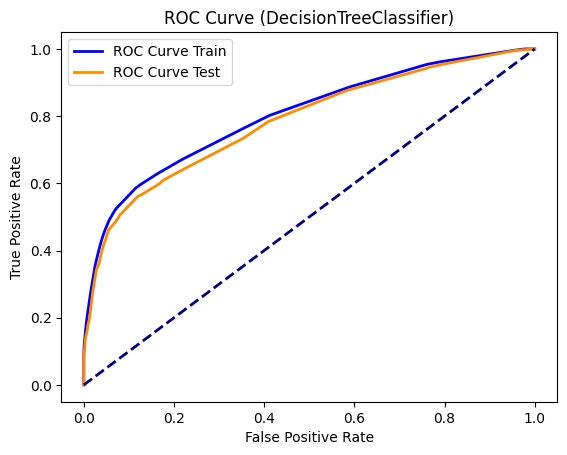

Optimal Threshold: 0.26
Optimal Training Precision: 0.59
Optimal Training Аccuracy: 0.82
Optimal Training Recall: 0.58
Optimal Test Precision: 0.57
Optimal Test Аccuracy: 0.81
Optimal Test Recall: 0.56
Optimal Test f1_score: 0.57


In [44]:
metrics_tree  = calculate_metrics_and_plot_roc(dt_classifier, X_train, y_train, X_test, y_test)

## XGBClassifier

In [45]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

def findXGBClassifier(X_train, y_train):
    param_grid = {
        'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
        'max_depth': [3, 5, 7, 9],
        'subsample': [0.5, 0.7, 0.9, 1],
        'colsample_bytree': [0.5, 0.7, 0.9, 1],
        'n_estimators': [n for n in np.arange(100, 300, 50)],
    }

    xgb_model = xgb.XGBClassifier(random_state=my_random_state, objective='binary:logistic')

    grid_search = GridSearchCV(estimator = xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Лучшие гиперпараметры
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Лучшие гиперпараметры: {best_params}")
    print(f"Лучшая точность на валидационной выборке: {best_score}")
    return grid_search

In [46]:
grid_search = findXGBClassifier(X_train, y_train)

Лучшие гиперпараметры: {'colsample_bytree': 1, 'eta': 0.05, 'max_depth': 5, 'n_estimators': np.int64(200), 'subsample': 0.9}
Лучшая точность на валидационной выборке: 0.839925925925926


In [47]:
# Создаем модель с лучшим параметры
XGB_clf = grid_search.best_estimator_

ROC-AUC Train: 0.86
ROC-AUC Test: 0.82


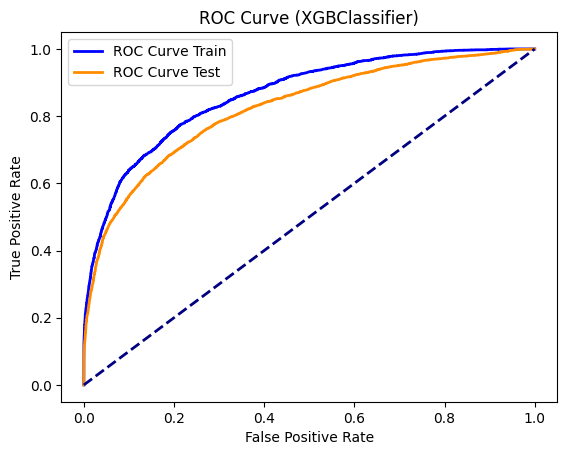

Optimal Threshold: 0.27
Optimal Training Precision: 0.60
Optimal Training Аccuracy: 0.83
Optimal Training Recall: 0.67
Optimal Test Precision: 0.56
Optimal Test Аccuracy: 0.81
Optimal Test Recall: 0.62
Optimal Test f1_score: 0.59


In [48]:
metrics_XGB  = calculate_metrics_and_plot_roc(XGB_clf, X_train, y_train, X_test, y_test)

## RandomForestClassifier

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def findRandomForestClassifier(X_train, y_train):

    param_grid = {
    'n_estimators': [n for n in np.arange(10, 200, 20)],
    'max_features' : ["sqrt", "log2"],
    'max_depth': [4, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

    # Поиск лучших гиперпараметров
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=my_random_state), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Лучшие гиперпараметры
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Лучшие гиперпараметры: {best_params}")
    print(f"Лучшая точность на валидационной выборке: {best_score}")
    return grid_search

In [50]:
grid_search = findRandomForestClassifier(X_train, y_train)

Лучшие гиперпараметры: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': np.int64(190)}
Лучшая точность на валидационной выборке: 0.8411111111111111


In [51]:
# Создаем модель с лучшим параметры
rf_clf = grid_search.best_estimator_

ROC-AUC Train: 0.91
ROC-AUC Test: 0.82


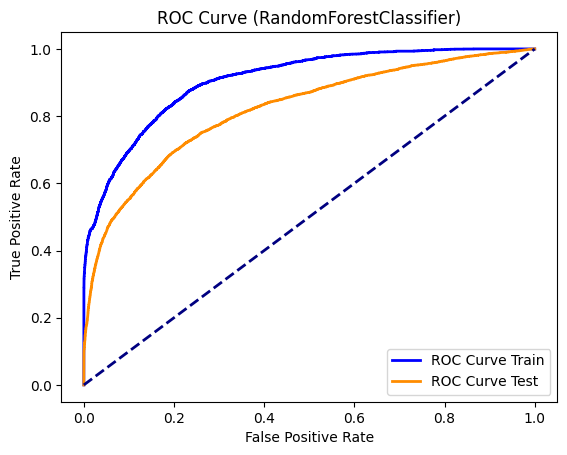

Optimal Threshold: 0.24
Optimal Training Precision: 0.65
Optimal Training Аccuracy: 0.85
Optimal Training Recall: 0.71
Optimal Test Precision: 0.56
Optimal Test Аccuracy: 0.81
Optimal Test Recall: 0.61
Optimal Test f1_score: 0.58


In [52]:
metrics_RF  = calculate_metrics_and_plot_roc(rf_clf, X_train, y_train, X_test, y_test)

## SVC

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Определяем сетку параметров для C и ядер, которые мы хотим проверить
param_grid = [{'kernel':['linear'], 'C': [1, 10, 100, 1000]},
    {'kernel':['sigmoid'], 'C':[1, 10, 100, 1000]},
    {'kernel': ['rbf'], 'gamma': [0.1, 0.5, 1, 5, 10], 'C':[1, 10, 100, 1000]}]

svm_model = SVC(random_state= my_random_state)

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train_scaled, y_train_scaled)

# Получаем лучшее значение параметра C и ядра, найденное в процессе кросс-валидации
print('Лучшее значение параметра:', grid_search.best_params_, " Оценка: ", grid_search.best_score_)

Лучшее значение параметра: {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}  Оценка:  0.8683703703703702


In [54]:
# Создаем модель с лучшим значением C и ядра
best_svm_model = SVC(**grid_search.best_params_, probability=True)

ROC-AUC Train: 0.86
ROC-AUC Test: 0.85


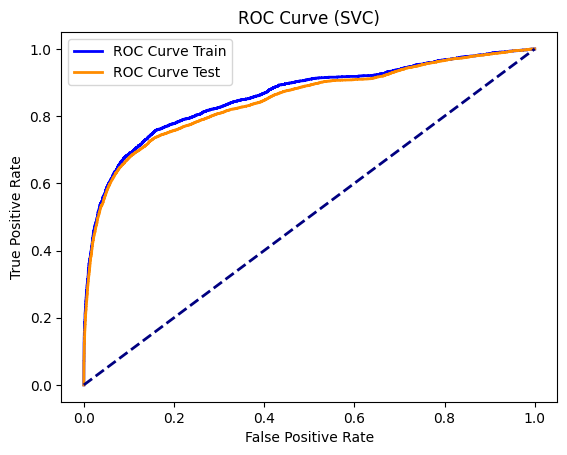

Optimal Threshold: 0.20
Optimal Training Precision: 0.70
Optimal Training Аccuracy: 0.86
Optimal Training Recall: 0.65
Optimal Test Precision: 0.70
Optimal Test Аccuracy: 0.86
Optimal Test Recall: 0.65
Optimal Test f1_score: 0.67


In [55]:
metrics_svm  = calculate_metrics_and_plot_roc(best_svm_model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

## KNeighborsClassifier

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def findKNeighborsClassifier(X_train, y_train):
    param_grid = {
        'n_neighbors': np.arange(1,50, 1),
        'leaf_size': np.arange(20,40,1),
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'chebyshev'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }

    knn_model = KNeighborsClassifier()

    grid_search = GridSearchCV(estimator = knn_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Лучшие гиперпараметры
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Лучшие гиперпараметры: {best_params}")
    print(f"Лучшая точность на валидационной выборке: {best_score}")
    return grid_search

In [57]:
grid_search = findKNeighborsClassifier(X_train_scaled,y_train_scaled)

Лучшие гиперпараметры: {'algorithm': 'auto', 'leaf_size': np.int64(20), 'metric': 'minkowski', 'n_neighbors': np.int64(30), 'weights': 'uniform'}
Лучшая точность на валидационной выборке: 0.8693333333333333


In [58]:
model_cl = grid_search.best_estimator_

ROC-AUC Train: 0.91
ROC-AUC Test: 0.88


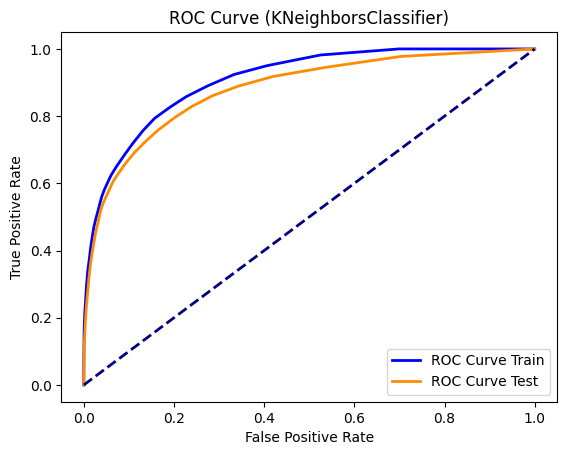

Optimal Threshold: 0.34
Optimal Training Precision: 0.68
Optimal Training Аccuracy: 0.86
Optimal Training Recall: 0.68
Optimal Test Precision: 0.67
Optimal Test Аccuracy: 0.85
Optimal Test Recall: 0.66
Optimal Test f1_score: 0.67


In [59]:
metrics_knn  = calculate_metrics_and_plot_roc(model_cl, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

## Сравнение моделей

In [60]:
metrics_df = {'model' : ['DecisionTreeClassifier', 'XGBClassifier', 'RandomForestClassifier', 'SVC', 'KNeighborsClassifier'],
              'Test Аccuracy' : [metrics_tree['values'][3], metrics_XGB['values'][3], metrics_RF['values'][3],metrics_svm['values'][3],metrics_knn['values'][3]], 
              'ROC_AUC_Test': [metrics_tree['values'][7], metrics_XGB['values'][7], metrics_RF['values'][7],metrics_svm['values'][7],metrics_knn['values'][7]], 
              'f1_score_Test' : [metrics_tree['values'][8], metrics_XGB['values'][8], metrics_RF['values'][8],metrics_svm['values'][8],metrics_knn['values'][8]]}
metrics_df = pd.DataFrame(metrics_df)
metrics_df

,model,Test Аccuracy,ROC_AUC_Test,f1_score_Test
0,DecisionTreeClassifier,0.81,0.78,0.57
1,XGBClassifier,0.81,0.82,0.59
2,RandomForestClassifier,0.81,0.82,0.58
3,SVC,0.86,0.85,0.67
4,KNeighborsClassifier,0.85,0.88,0.67


In [61]:
metrics_df.to_csv('metrics_df.csv', sep=',', index=False, encoding='utf-8')

Лучше себя показала модель SVC. Сохраним её и 2 и 3 по качеству модели(KNeighborsClassifier и XGBClassifier)

In [62]:
from joblib import dump

dump(XGB_clf, 'XGB_clf.joblib')
dump(best_svm_model, 'best_svm_model.joblib')
dump(model_cl, 'model_cl.joblib')

['model_cl.joblib']

# AutoML

In [63]:
X_train_df = pd.DataFrame(X_train_scaled, columns=['Признак 1', 'Признак 2'])
X_train_df

,Признак 1,Признак 2
0,1.30,-1.71
1,-0.34,-2.12
2,-1.86,0.62
3,-0.77,-1.28
4,-1.08,-1.82
...,...,...
13495,-0.53,-2.32
13496,-0.39,-1.08
13497,1.44,-1.28
13498,-0.37,1.34


In [64]:
X_test_df = pd.DataFrame(X_test_scaled, columns=['Признак 1', 'Признак 2'])
X_test_df

,Признак 1,Признак 2
0,1.39,-1.51
1,-0.97,0.81
2,-1.33,1.93
3,-1.50,-0.59
4,3.66,-0.31
...,...,...
31495,3.80,2.44
31496,-0.85,-1.11
31497,2.16,-1.12
31498,0.46,-1.77


In [ ]:
from flaml import AutoML

automl = AutoML()

parametrs = {
     "time_budget": 120,
     "metric": "accuracy",
     "task": "classification",
}

automl.fit(X_train=X_train_df, y_train=y_train_scaled,**parametrs)

[flaml.automl.logger: 03-31 21:06:44] {1728} INFO - task = classification
[flaml.automl.logger: 03-31 21:06:44] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 03-31 21:06:44] {1838} INFO - Minimizing error metric: 1-accuracy


[flaml.automl.logger: 03-31 21:06:44] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 03-31 21:06:44] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 03-31 21:06:45] {2393} INFO - Estimated sufficient time budget=1198s. Estimated necessary time budget=28s.
[flaml.automl.logger: 03-31 21:06:45] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.2209,	best estimator lgbm's best error=0.2209
[flaml.automl.logger: 03-31 21:06:45] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 03-31 21:06:45] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.2209,	best estimator lgbm's best error=0.2209
[flaml.automl.logger: 03-31 21:06:45] {2258} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 03-31 21:06:45] {2442} INFO -  at 0.4s,	estimator lgbm's best error=0.1405,	best estimator lgbm's best error=0.1405
[flaml.automl.logger: 03-31 21:06:45] {

In [96]:
print("Лучшая модель: ",automl.best_estimator)
print("Гиперпараметры лучшнй модели: ",automl.best_config)
print('Лучшая точность на тренировочной выборке: {0:.4g}'.format(1-automl.best_loss))

Лучшая модель:  xgb_limitdepth
Гиперпараметры лучшнй модели:  {'n_estimators': 5, 'max_depth': 5, 'min_child_weight': np.float64(0.135457657133558), 'learning_rate': np.float64(0.3840630599504844), 'subsample': np.float64(0.794741631646611), 'colsample_bylevel': np.float64(0.9282494375658424), 'colsample_bytree': 1.0, 'reg_alpha': np.float64(0.002751960545976165), 'reg_lambda': np.float64(0.5723674767180422)}
Лучшая точность на тренировочной выборке: 0.8686


## Оценка качества

ROC-AUC Train: 0.90
ROC-AUC Test: 0.88


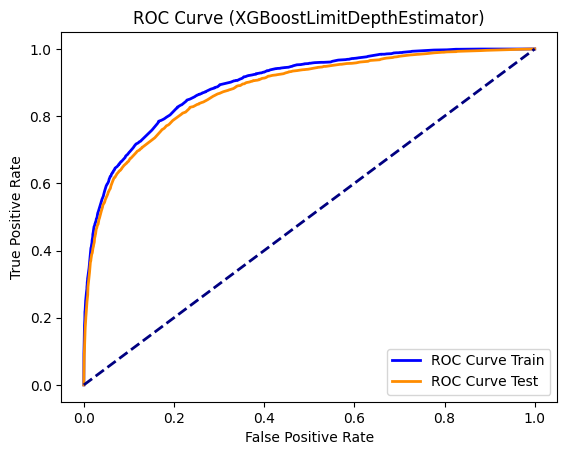

Optimal Threshold: 0.33
Optimal Training Precision: 0.73
Optimal Training Аccuracy: 0.87
Optimal Training Recall: 0.64
Optimal Test Precision: 0.71
Optimal Test Аccuracy: 0.86
Optimal Test Recall: 0.63
Optimal Test f1_score: 0.67


In [80]:
metrics_automl  = calculate_metrics_and_plot_roc(automl.model, X_train_df, y_train_scaled, X_test_df, y_test_scaled)

## Сравнение с результатами без AutoML

In [83]:
automl_df = {'model' : ['AutoML'],
              'Test Аccuracy' : [metrics_automl['values'][3]], 
              'ROC_AUC_Test': [metrics_automl['values'][7]], 
              'f1_score_Test' : [metrics_automl['values'][8]]}
automl_df = pd.DataFrame(automl_df)

In [84]:
metrics_df = pd.concat([metrics_df, automl_df], ignore_index=True)
metrics_df

,model,Test Аccuracy,ROC_AUC_Test,f1_score_Test
0,DecisionTreeClassifier,0.81,0.78,0.57
1,XGBClassifier,0.81,0.82,0.59
2,RandomForestClassifier,0.81,0.82,0.58
3,SVC,0.86,0.85,0.67
4,KNeighborsClassifier,0.85,0.88,0.67
5,AutoML,0.86,0.88,0.67


AutoML показал себя лучше лучшей модели SVC. 

Выгрузим AutoML

In [85]:
from joblib import dump

dump(automl.model, 'automl.joblib')

['automl.joblib']

Сохраняем таблицу для сравнения

In [97]:
metrics_df.to_csv('metrics_df_with_AutoML.csv', sep=',', index=False, encoding='utf-8')